# Isotropy redux

Here we will independently reproduce the conclusions from Will's Julia notebook. Begin with some standard imports:

In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
import seaborn as sns

sns.set(context='notebook', palette='colorblind')

# disable annoying seaborn warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

## Producing Cartesian vectors

We want to translate $(\alpha, \delta, \psi, \iota)$ into two Cartesian vectors representing the direction of the source location and orbital angular momentum in celestial coordinates.

To do this correctly, we need to follow the conventions assumed by LAL for the different angle definitions. Relevant documents are:
- https://lscsoft.docs.ligo.org/lalsuite/lalsimulation/group___l_a_l_simulation__h.html
- https://lscsoft.docs.ligo.org/lalsuite/lalsimulation/group__lalsimulation__inspiral.html
- https://dcc.ligo.org/public/0012/T010110/001/T010110.pdf

Note that the above documentations refers to two different "lines of nodes," without explicitly disambiguating:
- in relating the waveframe to the Earth frame [here](https://lscsoft.docs.ligo.org/lalsuite/lalsimulation/group___l_a_l_simulation__h.html) the polarization angle $\psi$ is defined as
> The angle from the **ascending line of nodes** to the X-axis of the wave plane. The angle is measured counter clockwise about the Z-axis of the wave plane.

Here "ascending line of nodes" refers to the Earth's line of nodes, defined to be the intersection of the Earth equator with the the wave XY plane (see [technical note](https://dcc.ligo.org/public/0012/T010110/001/T010110.pdf)).

- in relating the source frame [here](https://lscsoft.docs.ligo.org/lalsuite/lalsimulation/group__lalsimulation__inspiral.html) to the wave frame, the "longitude of ascending node" $\Omega$ is defined as
> The angle on the plane of the sky from the X-axis of the reference direction in the wave frame to the ascending node ☊ .

This line of nodes refers to the GW source (the binary), i.e., the intersection of the orbital plane with the plane of the sky (the wave XY plane), at the point where the orbiting objects cross from "under" to "above" (see diagram [here](https://lscsoft.docs.ligo.org/lalsuite/lalsimulation/group__lalsimulation__inspiral.html)).

_The two lines of nodes are unrelated and should not be confused!_

Also, regarding the construction of the orbital angular momentum vector $\vec{L}$, note the following note regarding the construction of the waveframe relative to the source frame in here](https://lscsoft.docs.ligo.org/lalsuite/lalsimulation/group__lalsimulation__inspiral.html):
> In the present implementation, the Y-axis in the wave frame is defined to be the ascending node ☊ . Therefore, Ω=π /2 by default with the consequences that the z axis lies in the X-Z plane, with positive projection over X.

where the (lower case) $z$ axis is defined to point along $\vec{L}$. This means that, to obtain $\vec{L}$, we can simply rotate the wave vector $\vec{Z}=\vec{k}$ by $\iota$ around $\vec{Y}$, following the right hand rule (or, equivalently rotate $\vec{X}$ defining the waveframe around its $\vec{Y}$ by $\iota - \pi/2$.)

In [3]:
def rotation_matrix(angle, direction):
    """Return the matrix effecting a rotation by angle, counterclockwise
    around the direction n (i.e. in the sense of the right-hand rule).
    """
    n = direction / linalg.norm(direction)
    costh, sinth = cos(angle), sin(angle)
    p = 1 - costh
    R = array([[costh + n[0]*n[0]*p,      n[0]*n[1]*p - n[2]*sinth, n[0]*n[2]*p + n[1]*sinth],
                [n[0]*n[1]*p + n[2]*sinth, costh + n[1]*n[1]*p,      n[1]*n[2]*p - n[0]*sinth],
                [n[0]*n[2]*p - n[1]*sinth, n[2]*n[1]*p + n[0]*sinth, costh + n[2]*n[2]*p]])
    return R
    
def get_location_vector(alpha, sindelta, *args):
    """Celestial coordinates are defined with alpha and delta as azimuthal 
    and (co)polar angles respectively, such that alpha = 0 corresponds to a
    source aligned with the March (vernal) equinox, which serves as X axis;
    delta = 0 corresponds to a source at the celestial equator, and so 
    sin(delta) is the Z coordinate along the celestial North
    """
    cosdelta = sqrt(1 - sindelta**2)
    x = cosdelta*cos(alpha)
    y = cosdelta*sin(alpha)
    z = sindelta
    return array([x, y, z])
    
def get_orientation_vector(alpha, sindelta, cosiota, psi, full_output=False):
    """iota is the polar angle between the line of sight and the orbital
    angular momentum, whereas psi is the in-sky angle between the angular
    momentum and the celestial East
    """
    # define celestial north
    north = array([0, 0, 1])
    # get wave-vector, which is Z in the waveframe
    n = get_location_vector(alpha, sindelta)
    k = -n
    # get local celestial West
    if abs(sindelta) == 1:
        # source at celestial North, need to disambiguate
        # waveframe orientation
        west = array([-cos(alpha+pi/2), -sin(alpha+pi/2), 0])
    else:
        west = cross(north, k)
        west /= linalg.norm(west)
    # the waveframe X is this vector rotated counterclockwise by psi around k,
    # as seen from Earth (i.e., following the right hand rule with thumb 
    # pointing towards k)
    wx = dot(rotation_matrix(psi, k), west)
    # finally rotate this vector, which lives in the plane of the sky,
    # such that it lies at an angle iota from z, i.e. rotate around Y
    wy = cross(k, wx)
    L = dot(rotation_matrix(arccos(cosiota), wy), k)
    if full_output:
        return L, west, wx/linalg.norm(wx), wy/linalg.norm(wy)
    else:
        return L

### Transformation checks

Let's check that the above functions are doing what they should be doing by plotting the relevant vectors in 3D

In [4]:
def plot_waveframe(alpha, sindelta, cosiota, psi):

    north = array([0, 0, 1])
    n = get_location_vector(alpha, sindelta)
    k = -n
    L, west, wx, wy = get_orientation_vector(alpha, sindelta, cosiota, psi, full_output=True)

    fig = plt.figure(dpi=150)
    ax = fig.add_subplot(projection='3d')

    # plot celestial axes
    for i in range(3):
        x = zeros((2, 3))
        x[1, i] = 1
        ax.plot(x[:,0], x[:,1], x[:,2], c='gray')

    # plot source location
    x = vstack([zeros(3), n])
    ax.plot(x[:,0], x[:,1], x[:,2], ls='--', label=r'$n$')
    ax.scatter(x[1:,0], x[1:,1], x[1:,2])

    # point source orientation and auxiliary vectors
    lkws = {
        tuple(west): dict(ls=':', c=sns.color_palette()[1], label='N/W'),
        tuple(north): dict(ls=':', c=sns.color_palette()[1]),
        tuple(wx): dict(c='crimson', label=r'$w_{x/y}$'),
        tuple(wy): dict(c='crimson'),
        tuple(L/2): dict(alpha=1, marker='o', label=r'$L$',
                         c=sns.color_palette()[2]),
    }

    def plot_sky_vector(v, **kws):
        m = kws.pop('marker', '.')
        kws['alpha'] = kws.get('alpha', 0.5)
        x = n + vstack([zeros(3), array(v)])
        l, = ax.plot(x[:,0], x[:,1], x[:,2], **kws)
        ax.scatter(x[1:,0], x[1:,1], x[1:,2], marker=m, color=l.get_color())

    for v, kws in lkws.items():
        plot_sky_vector(v, **kws)

    ax.set_xlim(-1., 1.)
    ax.set_ylim(-1., 1.)
    ax.set_zlim(-1., 1.)
    ax.set_box_aspect((1, 1, 1))

    legend(loc='center left', bbox_to_anchor=(1, 0.5));

    ax.view_init(30, 45)

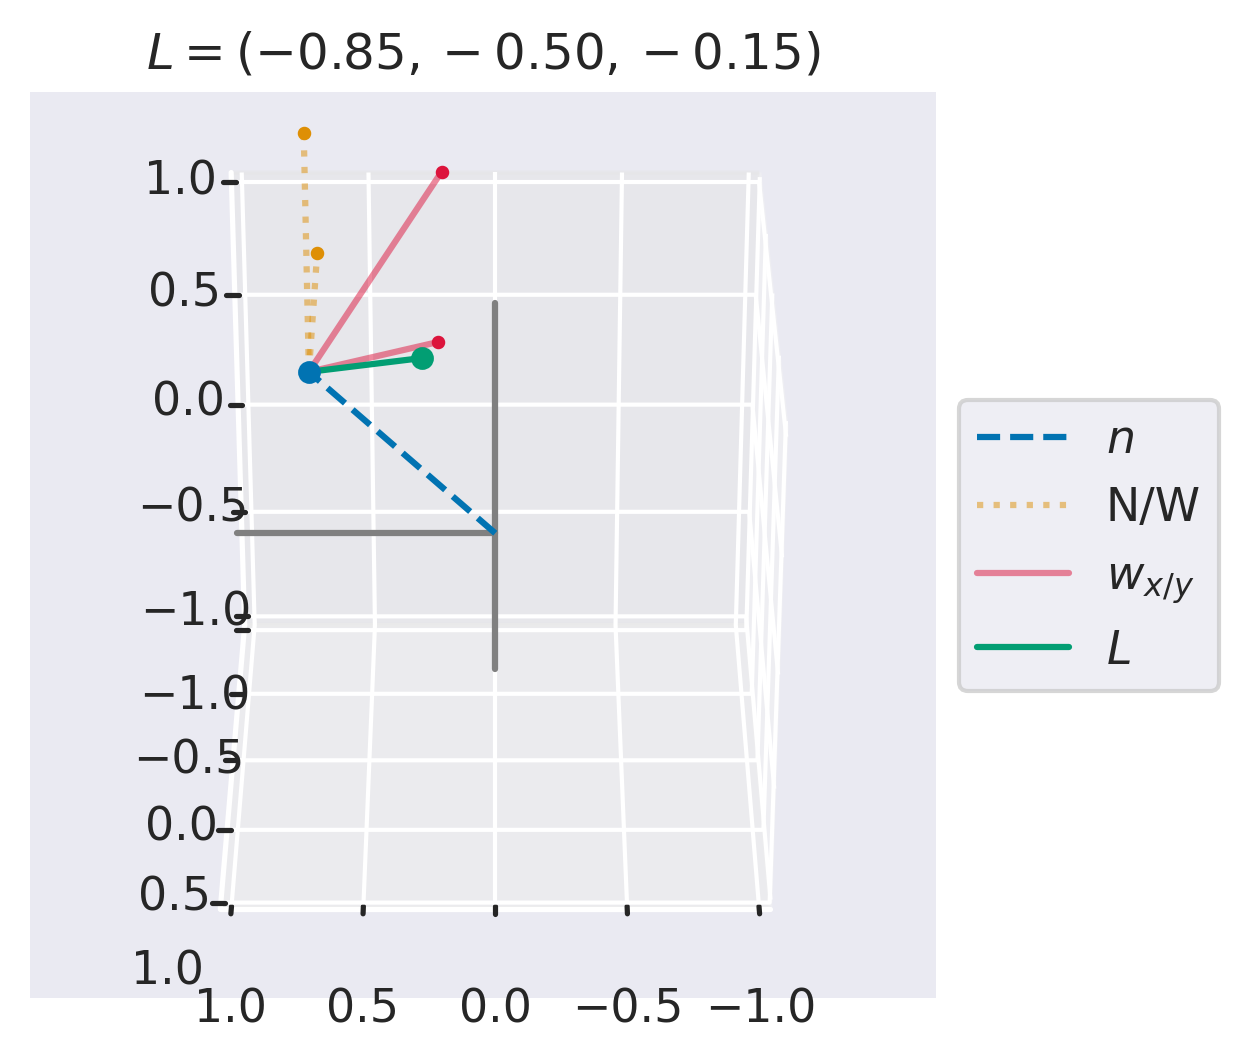

In [5]:
alpha = 0#pi/4
sindelta = sin(pi/4)
cosiota = cos(pi/4)
psi = pi/4

plot_waveframe(alpha, sindelta, cosiota, psi)
L = get_orientation_vector(alpha, sindelta, cosiota, psi)
title(r'$L = ({:.2f}, {:.2f}, {:.2f})$'.format(*L));

gca().view_init(30, 90)